In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
# 导入 HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 加载数据
# 假设 'housing.csv' 文件存在
df = pd.read_csv('housing.csv')

# 数据预处理
# 处理缺失值（如果有）
# HistGradientBoostingRegressor 可以处理 NaN 值，但为了保持与原代码的一致性，我们仍然删除缺失值
df = df.dropna()

# 处理分类变量 - 使用 One-Hot 编码
# HistGradientBoostingRegressor 默认需要数值型输入，所以 One-Hot 编码是合适的
df = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean')

# 分离特征和目标
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 创建并训练 HistGradientBoostingRegressor 模型
# 注意：HistGradientBoostingRegressor 的参数设置与随机森林有所不同
hgb_model = HistGradientBoostingRegressor(
    max_depth=19,             # 最大深度
    max_iter=250,             # 提升迭代次数 (树的数量)
    learning_rate=0.12,        # 学习率
    min_samples_leaf=45,      # 叶子节点最小样本数
    random_state=42,
    l2_regularization=0.4,
)
hgb_model.fit(X_train, y_train)


# 交叉验证
# 注意：对于 HistGradientBoostingRegressor 这种基于迭代的模型，
# 交叉验证可能会比较耗时，但步骤保持不变。
cv_scores = cross_val_score(
    hgb_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1 # 使用多核加速交叉验证
)

cv_rmse = np.sqrt(-cv_scores)
print(f"\n交叉验证 RMSE: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std():,.2f})")

# 预测和评估
y_pred = hgb_model.predict(X_test)

print("\n" + "=" * 50)
print("模型性能评估 (HistGradientBoostingRegressor)")
print("=" * 50)
print(f'RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}')
print(f'MAE: ${mean_absolute_error(y_test, y_pred):,.2f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')


交叉验证 RMSE: 46,329.54 (+/- 1,651.75)

模型性能评估 (HistGradientBoostingRegressor)
RMSE: $47,491.68
MAE: $31,523.53
R² Score: 0.8351


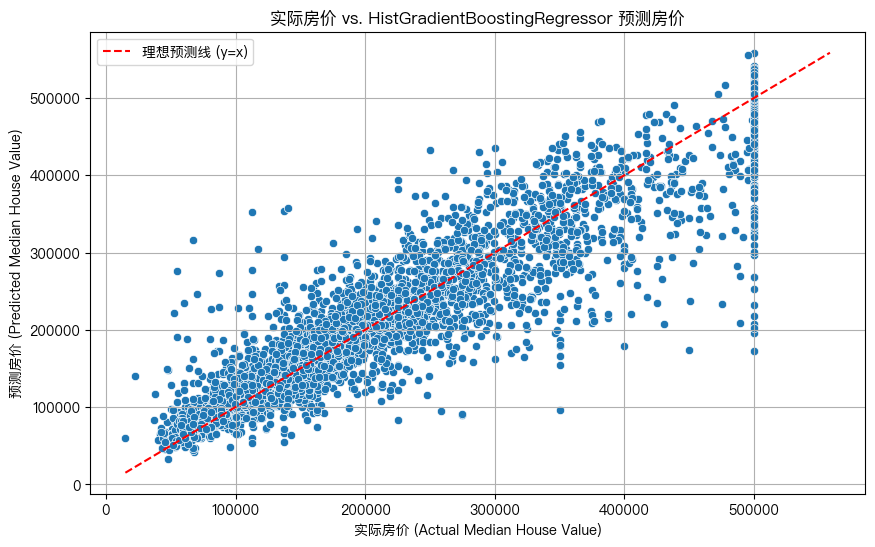

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import tree
matplotlib.rcParams['font.sans-serif'] = "PingFang HK"

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# 添加 y=x 参考线
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_test.min()) # 使用 y_test 的最小值来确定范围
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想预测线 (y=x)')

plt.title('实际房价 vs. HistGradientBoostingRegressor 预测房价')
plt.xlabel('实际房价 (Actual Median House Value)')
plt.ylabel('预测房价 (Predicted Median House Value)')
plt.legend()
plt.grid(True)
plt.show()

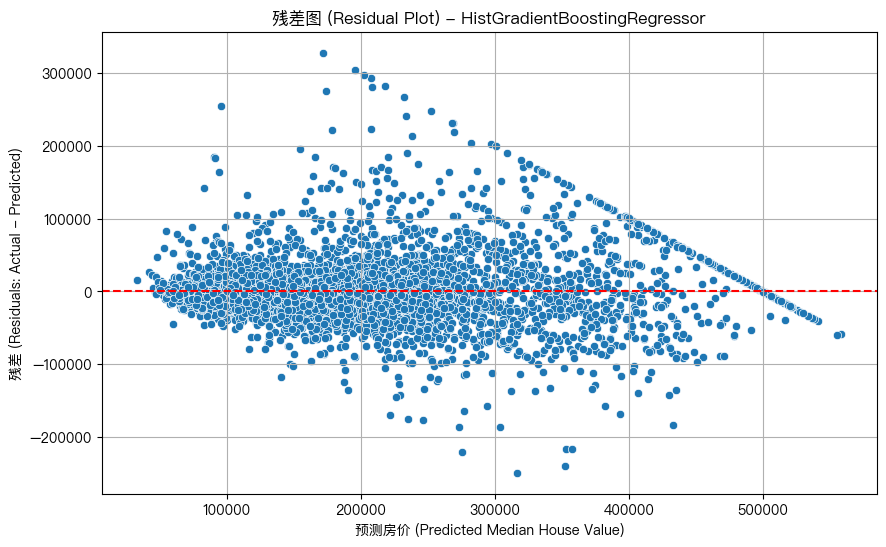

In [14]:
# 计算残差
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
# 绘制残差 vs 预测值
sns.scatterplot(x=y_pred, y=residuals) 

# 添加零线
plt.axhline(y=0, color='r', linestyle='--')

plt.title('残差图 (Residual Plot) - HistGradientBoostingRegressor')
plt.xlabel('预测房价 (Predicted Median House Value)')
plt.ylabel('残差 (Residuals: Actual - Predicted)')
plt.grid(True)
plt.show()

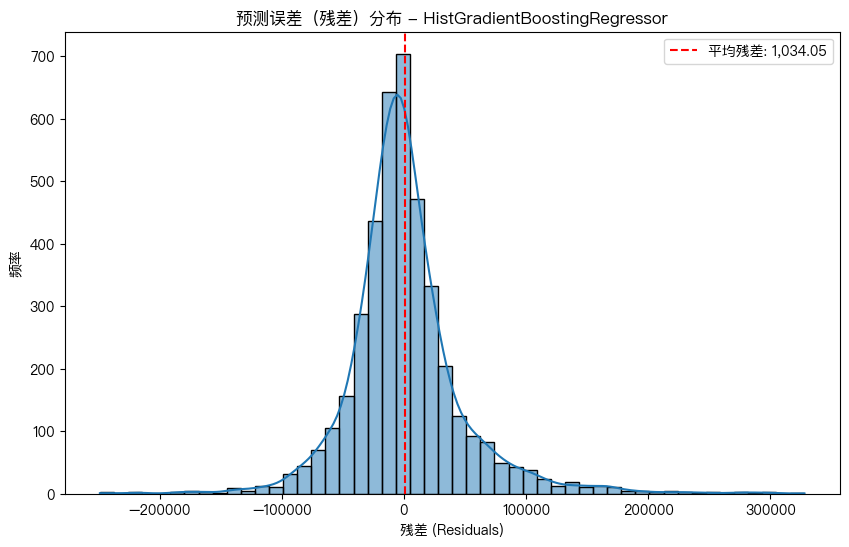

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)

# 添加平均残差线
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'平均残差: {residuals.mean():,.2f}')

plt.title('预测误差（残差）分布 - HistGradientBoostingRegressor')
plt.xlabel('残差 (Residuals)')
plt.ylabel('频率')
plt.legend()
plt.show()

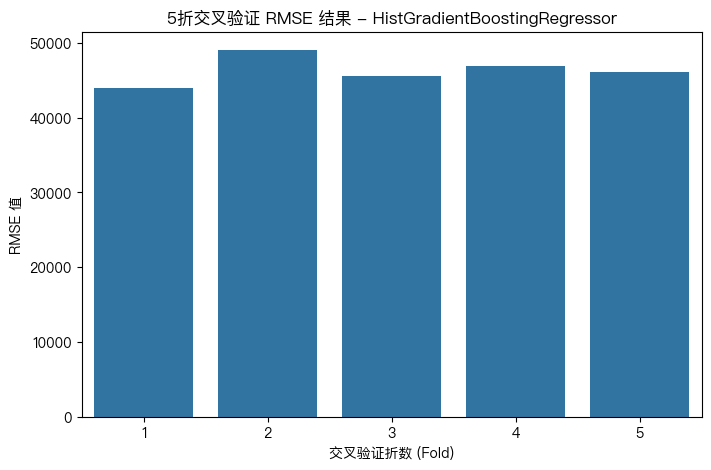

In [16]:

plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(cv_rmse) + 1)), y=cv_rmse)

plt.title('5折交叉验证 RMSE 结果 - HistGradientBoostingRegressor')
plt.xlabel('交叉验证折数 (Fold)')
plt.ylabel('RMSE 值')
plt.show()

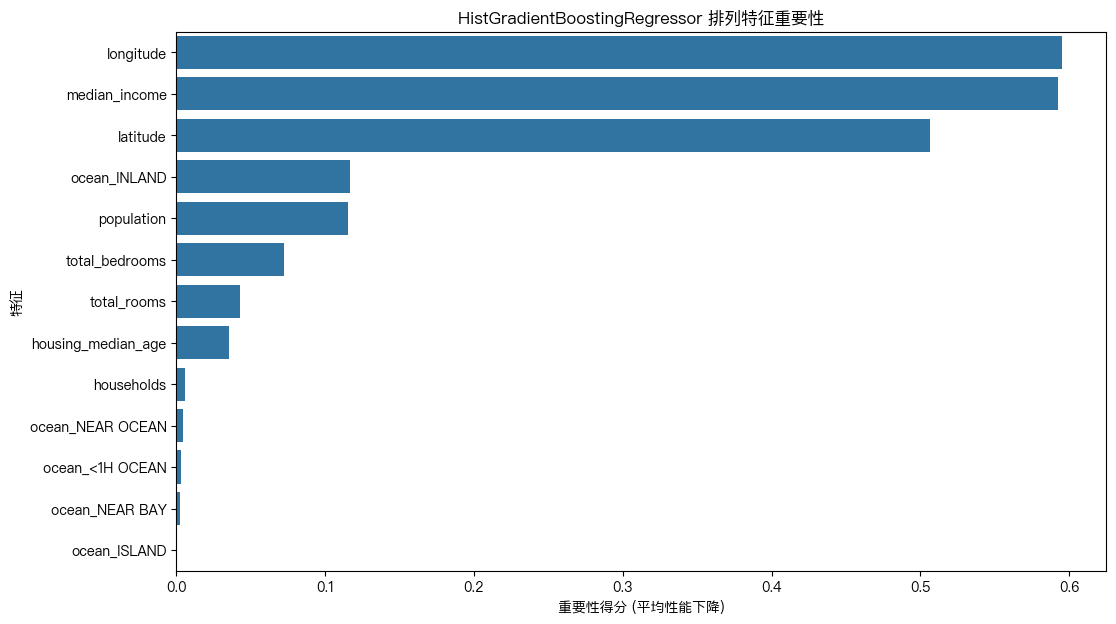

In [7]:
from sklearn.inspection import permutation_importance

# 计算排列重要性
# 使用测试集进行评估，以获得更真实的泛化性能
r = permutation_importance(
    hgb_model, 
    X_test, 
    y_test, 
    n_repeats=10, # 重复次数
    random_state=42, 
    n_jobs=-1
)

# 提取结果并排序
sorted_idx = r.importances_mean.argsort()[::-1]
importances = pd.Series(r.importances_mean[sorted_idx], index=X.columns[sorted_idx])

plt.figure(figsize=(12, 7))
sns.barplot(x=importances.values, y=importances.index)

plt.title('HistGradientBoostingRegressor 排列特征重要性')
plt.xlabel('重要性得分 (平均性能下降)')
plt.ylabel('特征')
plt.show()

# 模型超参数调优

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd


# 定义参数分布
param_distributions = {
    # 学习率：在 0.01 到 0.2 之间均匀采样
    'learning_rate': uniform(loc=0.01, scale=0.19), 

    # 树的数量：在 50 到 300 之间随机整数采样
    'max_iter': randint(50, 300), 

    # 最大深度：在 5 到 20 之间随机整数采样
    'max_depth': randint(5, 20), 

    # 叶子节点最小样本数：在 10 到 50 之间随机整数采样
    'min_samples_leaf': randint(10, 50),

    # L2 正则化：在 0.0 到 1.0 之间均匀采样
    'l2_regularization': uniform(loc=0.0, scale=1.0)
}

In [9]:
# 实例化模型
hgb = HistGradientBoostingRegressor(random_state=42)

# 实例化随机搜索对象
# n_iter: 尝试的参数组合数量
# cv: 交叉验证折数
# scoring: 评估指标（使用负均方误差，因为 RandomizedSearchCV 默认最大化分数）
# verbose: 输出详细程度
# n_jobs: 使用的 CPU 核心数
random_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_distributions,
    n_iter=50,  # 尝试 50 种不同的参数组合
    cv=5,       # 5 折交叉验证
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)


print("开始超参数随机搜索...")
random_search.fit(X_train, y_train)

# 获取最佳参数和最佳分数
best_params = random_search.best_params_
best_score = np.sqrt(-random_search.best_score_) # 转换回 RMSE

print("\n" + "=" * 50)
print("随机搜索最佳结果")
print("=" * 50)
print(f"最佳参数: {best_params}")
print(f"最佳交叉验证 RMSE: {best_score:,.2f}")

# 使用找到的最佳参数创建最终模型
final_hgb_model = HistGradientBoostingRegressor(**best_params, random_state=42)
final_hgb_model.fit(X_train, y_train)

# 在测试集上评估
y_pred_tuned = final_hgb_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
final_r2 = r2_score(y_test, y_pred_tuned)

print("\n" + "=" * 50)
print("调优后模型在测试集上的性能")
print("=" * 50)
print(f'测试集 RMSE: ${final_rmse:,.2f}')
print(f'测试集 R² Score: {final_r2:.4f}')

开始超参数随机搜索...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

随机搜索最佳结果
最佳参数: {'l2_regularization': np.float64(0.6174815096277165), 'learning_rate': np.float64(0.12621410049277337), 'max_depth': 17, 'max_iter': 285, 'min_samples_leaf': 34}
最佳交叉验证 RMSE: 46,632.90

调优后模型在测试集上的性能
测试集 RMSE: $46,816.74
测试集 R² Score: 0.8397


## 在随机搜索结果下进行更加精细的网格搜索

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np


# 定义基于随机搜索结果的精细参数网格
param_grid = {
    'learning_rate': [0.10, 0.12, 0.14, 0.16],
    'max_iter': [250, 280, 310],
    'max_depth': [15, 17, 19],
    'min_samples_leaf': [25, 35, 45],
    'l2_regularization': [0.4, 0.6, 0.8]
}

# 计算总共需要拟合的模型数量
total_fits = (
    len(param_grid['learning_rate']) * 
    len(param_grid['max_iter']) * 
    len(param_grid['max_depth']) * 
    len(param_grid['min_samples_leaf']) * 
    len(param_grid['l2_regularization']) * 
    5 # 5折交叉验证
)

print(f"网格搜索将尝试 {len(param_grid['learning_rate'])} * {len(param_grid['max_iter'])} * {len(param_grid['max_depth'])} * {len(param_grid['min_samples_leaf'])} * {len(param_grid['l2_regularization'])} = {total_fits // 5} 种参数组合。")
print(f"总共需要进行 {total_fits} 次模型拟合。")


# 实例化模型
hgb = HistGradientBoostingRegressor(random_state=42)

# 实例化网格搜索对象
grid_search = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=5,       # 5 折交叉验证
    scoring='neg_mean_squared_error', # 评估指标
    verbose=2,  # 输出详细程度
    n_jobs=-1   # 使用所有 CPU 核心
)

网格搜索将尝试 4 * 3 * 3 * 3 * 3 = 324 种参数组合。
总共需要进行 1620 次模型拟合。
[CV] END l2_regularization=0.15601864044243652, learning_rate=0.039638958863878505, max_depth=15, max_iter=252, min_samples_leaf=33; total time=   0.8s
[CV] END l2_regularization=0.6174815096277165, learning_rate=0.12621410049277337, max_depth=17, max_iter=285, min_samples_leaf=34; total time=   0.5s
[CV] END l2_regularization=0.23277134043030423, learning_rate=0.02721522256123595, max_depth=18, max_iter=100, min_samples_leaf=12; total time=   0.3s
[CV] END l2_regularization=0.9488855372533332, learning_rate=0.1934700862841663, max_depth=6, max_iter=299, min_samples_leaf=18; total time=   0.3s
[CV] END l2_regularization=0.6099966577826209, learning_rate=0.16830703322987123, max_depth=7, max_iter=255, min_samples_leaf=26; total time=   0.4s
[CV] END l2_regularization=0.18485445552552704, learning_rate=0.19422107927526613, max_depth=14, max_iter=93, min_samples_leaf=43; total time=   0.3s
[CV] END l2_regularization=0.3951502360018

In [11]:
print("\n开始超参数网格搜索...")
# 假设 X_train 和 y_train 已经加载并预处理
grid_search.fit(X_train, y_train) 

# 假设 fit 已经完成
best_params_grid = grid_search.best_params_
best_score_grid = np.sqrt(-grid_search.best_score_)

print("\n" + "=" * 50)
print("网格搜索最佳结果")
print("=" * 50)
print(f"最佳参数: {best_params_grid}")
print(f"最佳交叉验证 RMSE: {best_score_grid:,.2f}")


开始超参数网格搜索...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

网格搜索最佳结果
最佳参数: {'l2_regularization': 0.4, 'learning_rate': 0.12, 'max_depth': 19, 'max_iter': 250, 'min_samples_leaf': 45}
最佳交叉验证 RMSE: 46,358.98
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=15, max_iter=250, min_samples_leaf=25; total time=   0.5s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=15, max_iter=250, min_samples_leaf=45; total time=   0.4s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=15, max_iter=280, min_samples_leaf=35; total time=   0.7s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=15, max_iter=310, min_samples_leaf=25; total time=   0.4s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=17, max_iter=250, min_samples_leaf=25; total time=   0.4s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=17, max_iter=250, min_samples_leaf=35; total time=   0.5s
[CV] END l2_regularization=0.4, learning_rate=0.1, max_depth=